In [ ]:


# =================================================
# 1) تنظیمات اولیه برای استفاده بهینه از CPU / GPU
# =================================================
import tensorflow as tf
import os

num_threads =50
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

# بررسی و فعال‌سازی GPU (درصورت وجود)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        # فعال‌سازی تدریجی حافظه GPU (مانع از اشغال کل VRAM در ابتدا)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("[INFO] GPU memory growth enabled.")
        print("[INFO] Running on GPU:", physical_devices[0])
    except Exception as e:
        print("[WARNING] Could not set memory growth:", e)
else:
    print(f"[INFO] No accessible GPU found; using CPU with {num_threads} threads.")

[INFO] GPU memory growth enabled.
[INFO] Running on GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


<div dir="rtl" align="right">

### ایمپورت  کتابخانه‌های مورد نیاز

در این سلول کتابخانه‌های مختلفی برای پردازش داده‌ها، ایجاد مدل و ارزیابی نتایج وارد شده‌اند. نقش هر کتابخانه به شرح زیر است:

- **`numpy`**: برای عملیات ریاضی و کار با آرایه‌های چندبعدی. در این پروژه به‌ویژه برای نگهداری داده‌های اسپکتروگرام و انجام محاسبات استفاده می‌شود.
- **`librosa`**: یک کتابخانه‌ی پیشرفته برای پردازش صوت. از این کتابخانه برای بارگذاری فایل‌های صوتی، استخراج ویژگی‌ها (مانند اسپکتروگرام)، و تبدیل‌های صوتی استفاده می‌شود.
- **`librosa.display`**: برای نمایش داده‌های صوتی به صورت بصری، مانند رسم اسپکتروگرام.
- **`matplotlib.pyplot`**: برای ایجاد نمودارها و تجسم داده‌ها. در این پروژه برای رسم نمودارهایی مانند منحنی دقت و ماتریس درهم‌ریختگی استفاده می‌شود.
- **`seaborn`**: یک کتابخانه برای تجسم داده‌ها که امکانات بیشتری نسبت به Matplotlib ارائه می‌دهد و برای رسم نمودارهای زیبا به کار می‌رود.
- **`skimage.transform.resize`**: برای تغییر اندازه تصاویر به ابعاد ثابت (برای همگن‌سازی اسپکتروگرام‌ها).
- **`sklearn.model_selection.train_test_split`**: ابزاری برای تقسیم مجموعه داده به دو بخش آموزش و تست. این تقسیم‌بندی به ارزیابی عملکرد مدل کمک می‌کند.
- **`sklearn.metrics.confusion_matrix`**: برای ایجاد ماتریس درهم‌ریختگی که نشان‌دهنده عملکرد مدل در طبقه‌بندی داده‌ها است.
- **`sklearn.metrics.classification_report`**: گزارش جامعی از دقت، فراخوانی و امتیاز F1 برای هر کلاس ارائه می‌دهد.
- **`tensorflow.keras.utils.to_categorical`**: برای تبدیل برچسب‌های عددی به قالب One-Hot Encoding استفاده می‌شود.
- **`tensorflow.keras.models.Sequential`**: یک ساختار ساده و لایه‌محور برای تعریف مدل‌های شبکه عصبی.
- **`tensorflow.keras.layers`**: شامل انواع لایه‌های شبکه عصبی از جمله `Conv2D`, `MaxPool2D`, `Flatten`, `Dense` و `Dropout` برای طراحی مدل CNN.
- **`tensorflow.keras.optimizers.Adam`**: یک بهینه‌ساز قدرتمند مبتنی بر گرادیان که سرعت همگرایی مدل را بهبود می‌بخشد.

این کتابخانه‌ها، ابزارهای اصلی برای پیش‌پردازش داده‌ها، طراحی مدل شبکه عصبی و ارزیابی آن در این پروژه هستند.

</div>


In [ ]:

# =================================================
# 2) ایمپورت  کتابخانه‌های مورد نیاز
# =================================================
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
N_PLP = 13  # تعداد ضرایب PLP (معمولاً بین 12 تا 13 کافی است)


<div dir="rtl" align="right">

### توضیح تابع `load_and_preprocess_data` - بخش اول

این تابع یکی از بخش‌های کلیدی پروژه است که مسئول بارگذاری داده‌های صوتی، پردازش آن‌ها و تبدیل به اسپکتروگرام برای استفاده در مدل یادگیری عمیق می‌باشد. تابع شامل مراحل متعددی برای پیش‌پردازش دقیق داده‌های صوتی است. در ادامه بخش‌های مختلف این تابع توضیح داده می‌شوند:

#### ورودی‌های تابع

1. **`data_dir`**:
   - مسیر اصلی که شامل فولدرهای هر کلاس است.
   - هر فولدر نماینده‌ی یک کلاس خاص (مانند سبک موسیقی) می‌باشد و فایل‌های صوتی آن کلاس را در خود جای می‌دهد.

2. **`classes`**:
   - لیستی از نام کلاس‌ها که باید در داده‌ها پردازش شوند. این نام‌ها برای تطبیق فولدرها و تخصیص برچسب‌ها استفاده می‌شوند.

3. **`chunk_duration` و `overlap_duration`**:
   - تعیین‌کننده مدت زمان قطعاتی از فایل‌های صوتی که پردازش می‌شوند.
   - `chunk_duration` مشخص می‌کند که هر قطعه صوتی چه مدت طول داشته باشد (برحسب ثانیه).
   - `overlap_duration` مشخص می‌کند که قطعات صوتی چه میزان هم‌پوشانی داشته باشند.

4. **`sr`**:
   - نرخ نمونه‌برداری داده‌ها. اگر مقدار `None` باشد، از نرخ نمونه‌برداری فایل اصلی استفاده می‌شود.

5. **`n_fft`، `hop_length` و `window`**:
   - پارامترهای مربوط به محاسبات STFT (تبدیل فوریه کوتاه مدت):
     - `n_fft`: تعداد نقاط در تبدیل فوریه.
     - `hop_length`: میزان جابه‌جایی بین پنجره‌های متوالی.
     - `window`: نوع پنجره (مثلاً هانینگ).

</div>


<div dir="rtl" align="right">

### توضیح تابع `load_and_preprocess_data` - بخش دوم

#### سایر پارامترهای ورودی تابع

6. **`use_db_scale`**:
   - اگر مقدار `True` باشد، دامنه اسپکتروگرام‌ها به مقیاس دسی‌بل (dB) تبدیل می‌شود.
   - این گزینه برای کاهش مقادیر دامنه و افزایش وضوح در داده‌ها بسیار مفید است.

7. **`target_shape`**:
   - اندازه نهایی اسپکتروگرام‌ها (طول و عرض) برای استفاده در شبکه عصبی.
   - اسپکتروگرام‌ها قبل از پردازش به این اندازه تغییر داده می‌شوند.

8. **`padding_mode`**:
   - مشخص می‌کند که اگر قطعات صوتی کوتاه‌تر از اندازه مورد نظر باشند، با چه الگویی پر شوند.
   - معمولاً از مقدار `constant` برای پر کردن با صفر استفاده می‌شود.

9. **`normalize`**:
   - اگر مقدار `True` باشد، داده‌های اسپکتروگرام به مقادیر بین 0 و 1 نرمال‌سازی می‌شوند.
   - این عمل باعث همگن شدن داده‌ها و بهبود عملکرد مدل می‌شود.

10. **`trim_silence` و `top_db`**:
    - اگر `trim_silence` مقدار `True` داشته باشد، سکوت از ابتدا و انتهای فایل صوتی حذف می‌شود.
    - پارامتر `top_db` تعیین می‌کند که سکوت با چه حساسیتی حذف شود.

11. **`verbose`**:
    - اگر مقدار `True` باشد، اطلاعات بیشتری در زمان پردازش نمایش داده می‌شود.
    - این گزینه برای اشکال‌زدایی و بررسی مراحل پردازش بسیار مفید است.

#### ساختار داده‌ها

- **`data`**:
  - لیستی که اسپکتروگرام‌های تولیدشده برای هر قطعه صوتی را نگهداری می‌کند.
- **`labels`**:
  - لیستی که برچسب‌های عددی مرتبط با هر اسپکتروگرام را ذخیره می‌کند.

#### نمایش تنظیمات (در صورت فعال بودن `verbose`)
- در ابتدای اجرای تابع، تنظیمات کلیدی مانند مسیر داده‌ها، نرخ نمونه‌برداری، و پارامترهای تبدیل نمایش داده می‌شوند.
- این اطلاعات برای اطمینان از درستی تنظیمات و رفع مشکلات احتمالی مهم است.

</div>


<div dir="rtl" align="right">

### توضیح تابع `load_and_preprocess_data` - بخش سوم

#### حلقه پردازش کلاس‌ها

1. **مرور روی کلاس‌ها**:
   - برای هر کلاسی که در لیست `classes` مشخص شده است، یک حلقه اجرا می‌شود.
   - مسیر فولدر هر کلاس با ترکیب `data_dir` و نام کلاس تعیین می‌شود.

2. **بررسی وجود فولدر کلاس**:
   - اگر مسیر فولدر یک کلاس موجود نباشد، یک پیام هشدار نمایش داده می‌شود و پردازش آن کلاس رد می‌شود.

3. **مرور روی فایل‌های صوتی در هر فولدر**:
   - فایل‌های صوتی با فرمت `.wav` در فولدر مربوطه شناسایی می‌شوند.
   - سایر فایل‌ها نادیده گرفته می‌شوند.

4. **بارگذاری فایل‌های صوتی**:
   - با استفاده از تابع `librosa.load`، فایل صوتی به صورت داده عددی و نرخ نمونه‌برداری (`sample_rate`) بارگذاری می‌شود.
   - اگر بارگذاری با مشکل مواجه شود، یک پیام خطا نمایش داده می‌شود و فایل موردنظر رد می‌شود.

5. **حذف سکوت (اختیاری)**:
   - در صورت فعال بودن گزینه `trim_silence`، سکوت از ابتدا و انتهای فایل صوتی با استفاده از تابع `librosa.effects.trim` حذف می‌شود.
   - پارامتر `top_db` تعیین‌کننده حساسیت حذف سکوت است.

#### محاسبه اندازه قطعات

- **`chunk_samples`**:
  - تعداد نمونه‌هایی که معادل با مدت زمان `chunk_duration` هستند.
  - محاسبه می‌شود: `chunk_samples = chunk_duration * sample_rate`.

- **`overlap_samples`**:
  - تعداد نمونه‌هایی که معادل با مدت زمان `overlap_duration` هستند.
  - محاسبه می‌شود: `overlap_samples = overlap_duration * sample_rate`.

- **بررسی طول فایل صوتی**:
  - اگر طول فایل صوتی کمتر از اندازه یک قطعه باشد (`chunk_samples`)، فایل رد می‌شود و پردازش ادامه پیدا می‌کند.

</div>


<div dir="rtl" align="left">

### توضیح تابع `load_and_preprocess_data` - بخش چهارم

#### تقسیم فایل صوتی به قطعات (Chunks)

1. **تعداد قطعات**:
   - تعداد قطعات صوتی با توجه به طول فایل و میزان هم‌پوشانی محاسبه می‌شود:
     ```python
     num_chunks = int(np.ceil((len(audio_data) - chunk_samples)
                              / (chunk_samples - overlap_samples))) + 1
     ```
   - در صورت فعال بودن حالت `verbose`، تعداد قطعات محاسبه‌شده نمایش داده می‌شود.

2. **حلقه ایجاد قطعات**:
   - با استفاده از یک حلقه، فایل صوتی به قطعات جداگانه تقسیم می‌شود.
   - شروع و پایان هر قطعه با توجه به اندیس نمونه‌ها محاسبه می‌شود:
     ```python
     start = i_chunk * (chunk_samples - overlap_samples)
     end = start + chunk_samples
     chunk = audio_data[start:end]
     ```

3. **تکمیل قطعات کوتاه**:
   - اگر یک قطعه (به‌ویژه قطعه آخر) کوتاه‌تر از `chunk_samples` باشد، با مقدار صفر تکمیل می‌شود:
     ```python
     short_fall = chunk_samples - len(chunk)
     if short_fall > 0:
         chunk = np.pad(chunk, (0, short_fall), mode=padding_mode)
     ```

#### تولید اسپکتروگرام برای هر قطعه

1. **محاسبه STFT**:
   - با استفاده از تابع `librosa.stft`، تبدیل فوریه کوتاه مدت برای هر قطعه محاسبه می‌شود:
     ```python
     stft_result = librosa.stft(
         chunk,
         n_fft=n_fft,
         hop_length=hop_length,
         window=window
     )
     ```
   - خروجی `stft_result` یک آرایه دوبعدی است که شامل مقادیر دامنه و فاز است.

2. **محاسبه دامنه اسپکتروگرام**:
   - تنها مقادیر دامنه (Magnitude) استخراج می‌شوند:
     ```python
     spectrogram = np.abs(stft_result)
     ```

3. **تبدیل دامنه به مقیاس دسی‌بل (اختیاری)**:
   - اگر گزینه `use_db_scale` فعال باشد، دامنه به مقیاس دسی‌بل تبدیل می‌شود:
     ```python
     spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
     ```

</div>


<div dir="rtl" align="left">

### توضیح تابع `load_and_preprocess_data` - بخش پنجم

#### پردازش نهایی اسپکتروگرام‌ها

1. **افزودن بعد کانال (اختیاری)**:
   - اسپکتروگرام‌ها از حالت دوبعدی به حالت سه‌بعدی (ارتفاع، عرض، تعداد کانال‌ها) تبدیل می‌شوند:
     ```python
     spectrogram = np.expand_dims(spectrogram, axis=-1)
     ```

2. **تغییر اندازه اسپکتروگرام‌ها**:
   - برای یکسان‌سازی ابعاد ورودی به مدل، اسپکتروگرام‌ها به ابعاد مشخص‌شده در `target_shape` تغییر اندازه داده می‌شوند:
     ```python
     spectrogram = resize(spectrogram, (*target_shape,))
     ```

3. **نرمال‌سازی مقادیر (اختیاری)**:
   - اگر گزینه `normalize` فعال باشد، مقادیر اسپکتروگرام‌ها به بازه ۰ تا ۱ نرمال‌سازی می‌شوند:
     ```python
     if normalize:
         min_val = spectrogram.min()
         max_val = spectrogram.max()
         if (max_val - min_val) != 0:
             spectrogram = (spectrogram - min_val) / (max_val - min_val)
         else:
             spectrogram = np.zeros_like(spectrogram)
     ```

4. **افزودن اسپکتروگرام به داده‌ها**:
   - اسپکتروگرام پردازش‌شده به لیست `data` اضافه می‌شود.
   - برچسب مرتبط با کلاس نیز به لیست `labels` اضافه می‌گردد:
     ```python
     data.append(spectrogram)
     labels.append(class_index)
     ```

#### تبدیل لیست‌ها به آرایه‌های عددی

- پس از پردازش تمامی فایل‌های صوتی، داده‌ها و برچسب‌ها به آرایه‌های Numpy تبدیل می‌شوند:
  ```python
  data = np.array(data, dtype=np.float32)
  labels = np.array(labels, dtype=np.int64)


In [ ]:
def load_and_preprocess_data(
    data_dir,
    classes,
    chunk_duration=4.0,
    overlap_duration=2.0,
    sr=None,
    n_fft=2048,
    hop_length=512,
    window='hann',
    use_db_scale=True,
    target_shape=(150, 150),
    padding_mode='constant',
    normalize=False,
    trim_silence=False,
    top_db=20,
    verbose=True
):
    data = []
    labels = []

    # شمارنده برای نمایش فقط 3 نمونه
    visualized_samples = 0

    if verbose:
        print("=== Audio Preprocessing Configuration ===")
        print(f"data_dir       : {data_dir}")
        print(f"classes        : {classes}")
        print(f"chunk_duration : {chunk_duration}s, overlap: {overlap_duration}s")
        print(f"sr             : {sr} (None means use file sr)")
        print(f"n_fft          : {n_fft}")
        print(f"hop_length     : {hop_length}")
        print(f"window         : {window}")
        print(f"use_db_scale   : {use_db_scale}")
        print(f"target_shape   : {target_shape}")
        print(f"padding_mode   : {padding_mode}")
        print(f"normalize      : {normalize}")
        print(f"trim_silence   : {trim_silence} (top_db={top_db})")
        print("=========================================\n")

    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        if verbose:
            print(f"[INFO] Processing class: {class_name} (folder: {class_dir})")

        if not os.path.isdir(class_dir):
            if verbose:
                print(f"[WARNING] Skipping: {class_dir} is not a directory.")
            continue

        for filename in os.listdir(class_dir):
            if not filename.lower().endswith('.wav'):
                continue  # فقط فایل‌های WAV

            file_path = os.path.join(class_dir, filename)
            if verbose:
                print(f"    Loading file: {filename}", end=' ... ')

            # تلاش برای بارگذاری فایل WAV
            try:
                audio_data, sample_rate = librosa.load(file_path, sr=sr)
            except Exception as e:
                if verbose:
                    print(f"\n[ERROR] Could not load {filename}: {e}")
                continue

            if verbose:
                print(f"Done. sr={sample_rate}, length={len(audio_data)} samples.")

            # حذف سکوت ابتدا و انتها در صورت نیاز
            if trim_silence:
                trimmed_audio, _ = librosa.effects.trim(audio_data, top_db=top_db)
                if len(trimmed_audio) > 0:
                    audio_data = trimmed_audio

            # محاسبه نمونه‌های قطعه / اورلپ
            chunk_samples = int(chunk_duration * sample_rate)
            overlap_samples = int(overlap_duration * sample_rate)

            # رد کردن فایل‌های کوتاه‌تر از اندازه‌ی قطعه
            if len(audio_data) < chunk_samples:
                if verbose:
                    print(f"    [WARNING] Skipping {filename}: length < {chunk_samples} samples.")
                continue

            # تعداد قطعات
            num_chunks = int(np.ceil((len(audio_data) - chunk_samples)
                                     / (chunk_samples - overlap_samples))) + 1
            if verbose:
                print(f"    -> Splitting into {num_chunks} chunks...")

            for i_chunk in range(num_chunks):
                start = i_chunk * (chunk_samples - overlap_samples)
                end = start + chunk_samples
                chunk = audio_data[start:end]

                # اگر این chunk کوتاه است (مثلاً آخرین تکه)، صفرپر می‌کنیم
                short_fall = chunk_samples - len(chunk)
                if short_fall > 0:
                    chunk = np.pad(chunk, (0, short_fall), mode=padding_mode)

                # محاسبه STFT و اسپکتروگرام
                stft_result = librosa.stft(
                    chunk,
                    n_fft=n_fft,
                    hop_length=hop_length,
                    window=window
                )
                spectrogram = np.abs(stft_result)

                # در صورت نیاز تبدیل به dB
                if use_db_scale:
                    spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

                # ---------- نمایش 3 نمونه اسپکتروگرام قبل و بعد از ریسایز ----------
                # شرط نمایش حداکثر 3 نمونه
                if visualized_samples < 3:
                    # اسپکتروگرام اصلی (2D) برای نمایش
                    original_spec = spectrogram.copy()

                    # تغییر اندازه برای نمایش
                    resized_spec = resize(original_spec, (*target_shape,))

                    # رسم شکل
                    plt.figure(figsize=(12, 5))

                    # زیرنمودار 1: اسپکتروگرام اصلی
                    plt.subplot(1, 2, 1)
                    librosa.display.specshow(original_spec, sr=sample_rate,
                                             hop_length=hop_length,
                                             x_axis='time', y_axis='hz',
                                             cmap='viridis')
                    plt.colorbar(format='%+2.0f dB')
                    plt.title("Original Spectrogram")

                    # زیرنمودار 2: اسپکتروگرام ریسایز شده
                    plt.subplot(1, 2, 2)
                    plt.imshow(resized_spec, aspect='auto', cmap='viridis')
                    plt.colorbar()
                    plt.title("Resized Spectrogram")

                    plt.tight_layout()
                    plt.show()

                    visualized_samples += 1
                # ---------------------------------------------------------------

                # افزودن بعد کانال (H,W) -> (H,W,1)
                spectrogram = np.expand_dims(spectrogram, axis=-1)

                # تغییر اندازه به ابعاد موردنظر
                spectrogram = resize(spectrogram, (*target_shape,))

                # نرمال‌سازی در صورت فعال بودن
                if normalize:
                    min_val = spectrogram.min()
                    max_val = spectrogram.max()
                    if (max_val - min_val) != 0:
                        spectrogram = (spectrogram - min_val) / (max_val - min_val)
                    else:
                        spectrogram = np.zeros_like(spectrogram)

                data.append(spectrogram)
                labels.append(class_index)

        if verbose:
            print(f"[INFO] Finished class: {class_name}\n")

    # تبدیل به آرایه‌های Numpy
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    if verbose:
        print(f"Final Data shape: {data.shape}")
        print(f"Final Labels shape: {labels.shape}")

    return data, labels

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


folder_path = '/content/drive/My Drive/yadgiri/Music Genre Classification System'
for file_name in os.listdir(folder_path):
    print(file_name)


data_dir = "/content/drive/My Drive/yadgiri/Music Genre Classification System/Data/genres_original"  # پوشه‌ی اصلی که ژانرها در زیرشاخه‌های آن هستند
classes = ['blues', 'classical','country','disco','hiphop',
           'jazz','metal','pop','reggae','rock']




Mounted at /content/drive
Trained_model.h5
temp_audio_file.mp3
Data
test_music


<div dir="rtl" align="right">

### بارگذاری و پیش‌پردازش داده -

#### `load_and_preprocess_data`
- تابع `load_and_preprocess_data` برای بارگذاری و پردازش فایل‌های صوتی از مسیر مشخص‌شده استفاده می‌شود. این تابع داده‌های صوتی را به قطعات کوچک‌تر تقسیم کرده و برای هر قطعه اسپکتروگرام تولید می‌کند.
- با استفاده از تنظیمات تعریف‌شده، داده‌ها به شکل استاندارد و آماده برای ورودی مدل شبکه عصبی تبدیل می‌شوند.

#### `data_dir` و `classes`
- `data_dir` مسیر اصلی داده‌ها است که شامل زیرفولدرهایی برای هر کلاس (مانند سبک‌های موسیقی) است.
- `classes` لیستی از نام کلاس‌هاست که به ترتیب مشخص می‌کند کدام کلاس‌ها باید پردازش شوند.

#### `chunk_duration` و `overlap_duration`
- `chunk_duration` مشخص می‌کند که هر قطعه صوتی چه مدت طول داشته باشد.
- `overlap_duration` میزان هم‌پوشانی بین قطعات را تعیین می‌کند. این هم‌پوشانی کمک می‌کند اطلاعات مفید در مرز قطعات از دست نرود.

#### `n_fft`، `hop_length` و `window`
- این پارامترها مربوط به تبدیل فوریه کوتاه مدت (STFT) هستند.
- `n_fft` تعداد نقاط در هر پنجره FFT را مشخص می‌کند.
- `hop_length` فاصله زمانی بین دو پنجره متوالی را تعیین می‌کند.
- `window` نوع پنجره (مثلاً هانینگ) را برای جلوگیری از نشت فرکانس مشخص می‌کند.

#### `target_shape`
- تمامی اسپکتروگرام‌های تولیدشده به اندازه مشخص‌شده در `target_shape` تغییر داده می‌شوند. این کار تضمین می‌کند که ورودی مدل شبکه عصبی ابعاد یکنواخت داشته باشد.

#### `normalize` و `trim_silence`
- اگر `normalize` فعال باشد، مقادیر اسپکتروگرام به بازه ۰ تا ۱ نرمال‌سازی می‌شوند.
- اگر `trim_silence` فعال باشد، سکوت از ابتدا و انتهای فایل صوتی حذف می‌شود تا داده‌های غیرضروری کاهش یابد.

#### `labels` و `to_categorical`
- برچسب‌های داده‌ها (`labels`) برای هر کلاس به صورت عددی تولید می‌شوند.
- این برچسب‌ها سپس با استفاده از تابع `to_categorical` به فرمت One-Hot Encoding تبدیل می‌شوند تا هر کلاس به صورت یک بردار دودویی نمایش داده شود.

#### اهمیت این مرحله
- `load_and_preprocess_data` تمامی فایل‌های صوتی را به داده‌های عددی استاندارد تبدیل می‌کند که برای آموزش مدل شبکه عصبی مناسب هستند.
- تبدیل برچسب‌ها به فرمت One-Hot تضمین می‌کند که مدل بتواند دسته‌بندی چندکلاسه را به درستی انجام دهد.

</div>


=== Audio Preprocessing Configuration ===
data_dir       : /content/drive/My Drive/yadgiri/Music Genre Classification System/Data/genres_original
classes        : ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
chunk_duration : 4.0s, overlap: 2.0s
sr             : None (None means use file sr)
n_fft          : 2048
hop_length     : 512
window         : hann
use_db_scale   : True
target_shape   : (150, 150)
padding_mode   : constant
normalize      : False
trim_silence   : False (top_db=20)

[INFO] Processing class: blues (folder: /content/drive/My Drive/yadgiri/Music Genre Classification System/Data/genres_original/blues)
    Loading file: blues.00058.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 chunks...


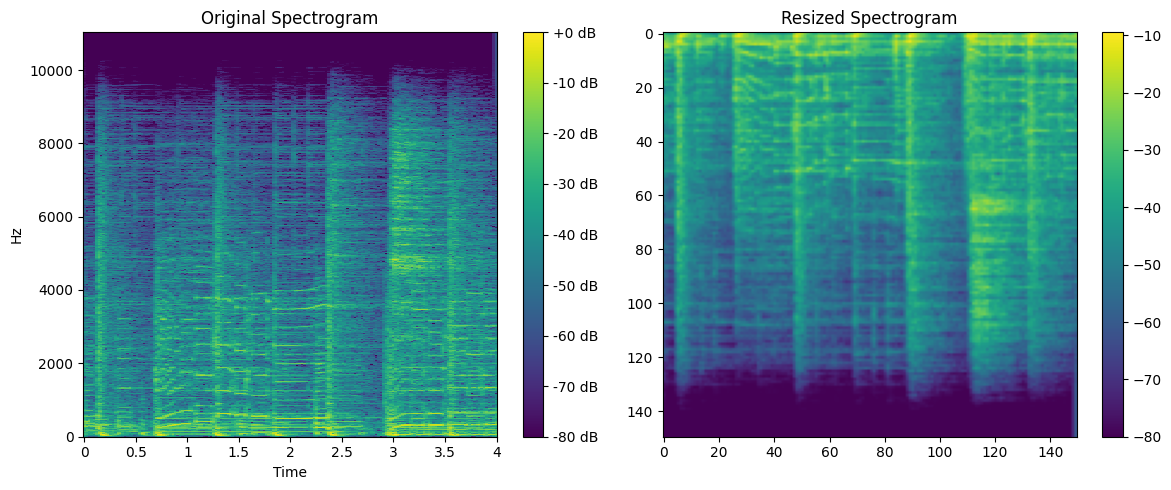

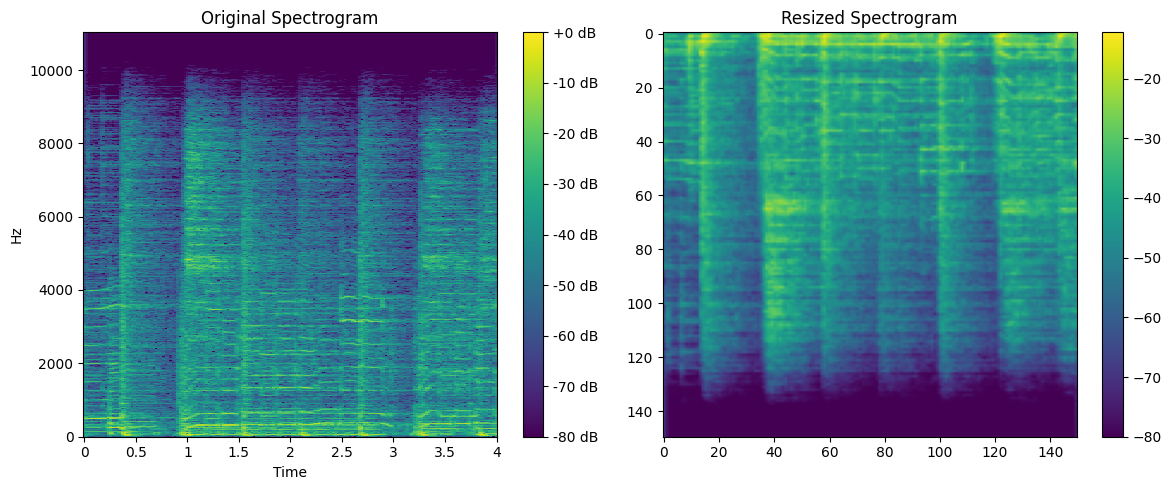

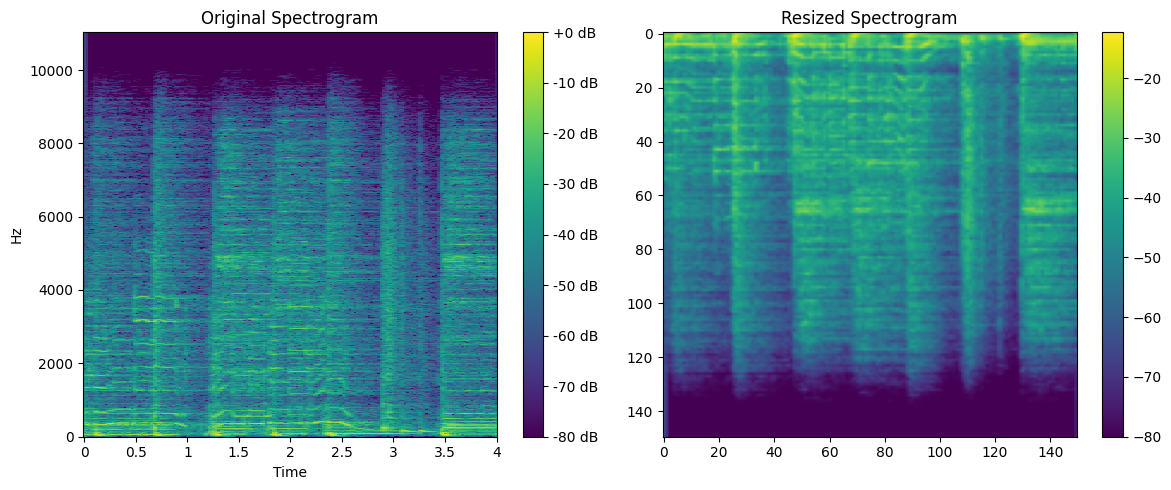

    Loading file: blues.00085.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 chunks...
    Loading file: blues.00012.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 chunks...
    Loading file: blues.00005.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 chunks...
    Loading file: blues.00037.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 chunks...
    Loading file: blues.00011.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 chunks...
    Loading file: blues.00039.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 chunks...
    Loading file: blues.00042.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 chunks...
    Loading file: blues.00073.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 chunks...
    Loading file: blues.00019.wav ... Done. sr=22050, length=661794 samples.
    -> Splitting into 15 ch

KeyboardInterrupt: 

In [ ]:

# =================================================
# 5) بارگذاری و پیش‌پردازش داده
# =================================================
data, labels = load_and_preprocess_data(
    data_dir=data_dir,
    classes=classes,
    chunk_duration=4.0,
    overlap_duration=2.0,
    sr=None,            # نرخ نمونه‌برداری فایل اصلی حفظ شود
    n_fft=2048,
    hop_length=512,
    window='hann',
    use_db_scale=True,
    target_shape=(150, 150),
    padding_mode='constant',
    normalize=False,
    trim_silence=False, # درصورت تمایل، True شود
    top_db=20,
    verbose=True
)

# تبدیل برچسب‌ها به One-Hot
num_classes = len(classes)
labels = to_categorical(labels, num_classes=num_classes)


<div dir="rtl" align="right">

### جدا کردن داده به آموزش و تست - بخش ششم

#### `train_test_split`
- در این بخش، داده‌ها با استفاده از تابع `train_test_split` از کتابخانه `scikit-learn` به دو مجموعه‌ی جداگانه تقسیم می‌شوند:
  - **داده‌های آموزشی (`X_train`, `y_train`)**: برای آموزش مدل استفاده می‌شوند.
  - **داده‌های تست (`X_test`, `y_test`)**: برای ارزیابی عملکرد مدل به کار می‌روند.
  
#### پارامترهای `train_test_split`
- **`data` و `labels`**:
  - آرایه‌ی اسپکتروگرام‌ها (`data`) و برچسب‌های مربوط به آن‌ها (`labels`) به عنوان ورودی به این تابع داده می‌شوند.
- **`test_size=0.2`**:
  - ۲۰ درصد داده‌ها برای تست در نظر گرفته می‌شوند، در حالی که ۸۰ درصد باقی‌مانده برای آموزش استفاده می‌شوند.
- **`random_state=42`**:
  - برای بازتولیدپذیری نتایج، یک مقدار ثابت برای حالت تصادفی تنظیم می‌شود. این باعث می‌شود که هر بار اجرای کد، داده‌ها به همان شکل قبلی تقسیم شوند.
- **`shuffle=True`**:
  - داده‌ها پیش از تقسیم به صورت تصادفی مرتب می‌شوند. این کار به جلوگیری از بایاس در داده‌ها کمک می‌کند.

#### `X_train` و `X_test`
- `X_train` شامل اسپکتروگرام‌های آموزشی است.
- `X_test` شامل اسپکتروگرام‌های تست است.

#### `y_train` و `y_test`
- `y_train` شامل برچسب‌های مربوط به داده‌های آموزشی است.
- `y_test` شامل برچسب‌های مربوط به داده‌های تست است.

#### پیام اطلاعات (`print`)
- پس از تقسیم داده‌ها، اندازه‌ی هر مجموعه چاپ می‌شود تا صحت تقسیم‌بندی بررسی شود.
- پیام‌های چاپ‌شده شامل موارد زیر است:
  - **`Train shape`**: نشان‌دهنده تعداد نمونه‌های آموزشی و ابعاد آن‌ها.
  - **`Test shape`**: نشان‌دهنده تعداد نمونه‌های تست و ابعاد آن‌ها.

#### اهمیت این مرحله
- تقسیم داده‌ها به دو بخش جداگانه تضمین می‌کند که مدل آموزش‌دیده بتواند بر داده‌های جدید (که در فرآیند آموزش استفاده نشده‌اند) تعمیم پیدا کند.
- استفاده از مجموعه تست برای ارزیابی عملکرد مدل کمک می‌کند تا مدل دچار overfitting نشود.

</div>


In [ ]:

# =================================================
# 6) جدا کردن داده به آموزش و تست
# =================================================
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("[INFO] Data split:")
print("  Train shape:", X_train.shape, y_train.shape)
print("  Test  shape:", X_test.shape,  y_test.shape)


[INFO] Data split:
  Train shape: (11980, 150, 150, 1) (11980, 10)
  Test  shape: (2995, 150, 150, 1) (2995, 10)


<div dir="rtl" align="right">

### ساخت مدل CNN پیشرفته - بخش هفتم

#### `Sequential`
- مدل با استفاده از ساختار **`Sequential`** از کتابخانه `Keras` ایجاد می‌شود.
- این ساختار امکان تعریف مدل به صورت لایه‌به‌لایه را فراهم می‌کند، جایی که خروجی هر لایه به عنوان ورودی لایه‌ی بعدی استفاده می‌شود.

#### بلوک‌های شبکه عصبی کانولوشنی (CNN)

##### **بلوک اول**
- **`Conv2D`**:
  - اولین لایه کانولوشنی دارای ۳۲ فیلتر با اندازه ۳x۳ است.
  - `padding='same'` باعث می‌شود که ابعاد خروجی با ورودی برابر باشد.
  - تابع فعال‌سازی **`ReLU`** (Rectified Linear Unit) برای افزایش غیرخطی بودن مدل استفاده شده است.
  - شکل ورودی داده‌ها از `X_train` استخراج می‌شود که شامل (ارتفاع، عرض، تعداد کانال‌ها) است.
- **لایه کانولوشن دوم**:
  - یک لایه کانولوشنی اضافی با همان مشخصات اضافه شده است.
- **`MaxPool2D`**:
  - عملیات کاهش ابعاد با اندازه پنجره ۲x۲ و گام جابه‌جایی ۲ انجام می‌شود. این لایه با کاهش ابعاد ویژگی‌ها، تعداد محاسبات را کاهش داده و مهم‌ترین ویژگی‌ها را استخراج می‌کند.

##### **بلوک دوم**
- دو لایه کانولوشنی با ۶۴ فیلتر اضافه می‌شوند. مشخصات مشابه بلوک اول است.
- **`MaxPool2D`** برای کاهش ابعاد ویژگی‌ها استفاده می‌شود.

##### **بلوک سوم**
- تعداد فیلترها به ۱۲۸ افزایش یافته است. این افزایش باعث استخراج ویژگی‌های پیچیده‌تر می‌شود.
- لایه **`Dropout(0.3)`** اضافه می‌شود تا احتمال **overfitting** کاهش یابد. این لایه بخشی از نورون‌ها را به صورت تصادفی غیرفعال می‌کند.

##### **بلوک چهارم**
- تعداد فیلترها به ۲۵۶ افزایش یافته است. این باعث می‌شود شبکه بتواند ویژگی‌های دقیق‌تری را در داده‌های ورودی شناسایی کند.
- مشابه بلوک سوم، از `MaxPool2D` برای کاهش ابعاد و تمرکز بر ویژگی‌های مهم استفاده می‌شود.

##### **بلوک پنجم**
- تعداد فیلترها به ۵۱۲ افزایش یافته است که نشان‌دهنده پیچیدگی بیشتر این بلوک است.
- مشابه بلوک‌های قبلی، از کانولوشن، `MaxPool2D` و `Dropout` برای کاهش ابعاد و جلوگیری از overfitting استفاده می‌شود.

#### لایه‌های پایانی (Fully Connected)
1. **`Flatten`**:
   - خروجی سه‌بعدی از آخرین لایه کانولوشنی به یک بردار یک‌بعدی تبدیل می‌شود تا به لایه‌های متصل‌کامل ارسال شود.
2. **`Dense(units=1200, activation='relu')`**:
   - یک لایه متصل‌کامل با ۱۲۰۰ نورون اضافه می‌شود که از تابع فعال‌سازی ReLU استفاده می‌کند.
3. **`Dropout(0.45)`**:
   - احتمال overfitting در این مرحله نیز با غیرفعال کردن تصادفی نورون‌ها کاهش می‌یابد.
4. **`Dense(units=num_classes, activation='softmax')`**:
   - لایه خروجی برای دسته‌بندی چندکلاسه است. تابع فعال‌سازی **Softmax** احتمالات پیش‌بینی هر کلاس را تولید می‌کند.

#### `model.summary`
- خلاصه‌ای از ساختار مدل نمایش داده می‌شود که شامل تعداد پارامترها و لایه‌های شبکه است.

#### اهمیت این مرحله
- این مدل CNN با افزایش تعداد فیلترها در بلوک‌های مختلف و استفاده از لایه‌های Dropout طراحی شده است تا بتواند ویژگی‌های پیچیده را از داده‌های صوتی استخراج کند.
- این معماری برای مسائل دسته‌بندی چندکلاسه بسیار مناسب است و با جلوگیری از overfitting عملکرد بهتری ارائه می‌دهد.

</div>


In [ ]:

# =================================================
# 7) ساخت مدل CNN پیشرفته
# =================================================
model = Sequential()

# بلوک اول
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
                 input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# بلوک دوم
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# بلوک سوم
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Dropout(0.3))

# بلوک چهارم
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

# بلوک پنجم
model.add(Conv2D(filters=512, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=3, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))

model.add(Dropout(0.3))

# لایه‌های پایانی
model.add(Flatten())
model.add(Dense(units=1200, activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 17, 17, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 15, 15, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 5, 5, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1200)                │       2,458,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          12,010 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 7,182,458 (27.40 MB)

 Trainable params: 7,182,458 (27.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, Callback

# 1. توقف زودهنگام (EarlyStopping)
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # نظارت بر دقت اعتبارسنجی
    patience=10,             # توقف اگر در 10 دوره متوالی پیشرفت نداشته باشد
    restore_best_weights=True,  # بازگرداندن وزن‌های بهترین مدل
    verbose=1
)

# 2. کاهش نرخ یادگیری (ReduceLROnPlateau)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # نظارت بر مقدار تابع هزینه اعتبارسنجی
    factor=0.5,               # کاهش نرخ یادگیری به نصف مقدار فعلی
    patience=5,               # کاهش نرخ یادگیری اگر در 5 دوره متوالی پیشرفتی وجود نداشته باشد
    min_lr=1e-6,              # حداقل نرخ یادگیری
    verbose=1
)

# 3. ذخیره بهترین مدل (ModelCheckpoint)
model_checkpoint = ModelCheckpoint(
    filepath='best_model_spectrogram.keras',  # مسیر ذخیره بهترین مدل
    monitor='val_accuracy',                  # نظارت بر دقت اعتبارسنجی
    save_best_only=True,                     # ذخیره فقط بهترین مدل
    verbose=1
)

# 4. گزارش‌گیری CSV (CSVLogger)
csv_logger = CSVLogger(
    filename='training_log_spectrogram.csv',  # مسیر ذخیره لاگ
    append=True                              # اضافه کردن به فایل (درصورت وجود)
)

# 5. کالبک سفارشی برای نظارت دقیق
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_accuracy = logs.get('val_accuracy')
        train_accuracy = logs.get('accuracy')
        if val_accuracy and train_accuracy:
            print(f"[INFO] Epoch {epoch + 1}: Train Accuracy = {train_accuracy:.4f}, Val Accuracy = {val_accuracy:.4f}")
        if val_accuracy and val_accuracy >= 0.99:  # اگر دقت اعتبارسنجی به 99% رسید
            print(f"\n[INFO] Validation Accuracy reached {val_accuracy:.2f}. Stopping training...")
            self.model.stop_training = True

custom_callback = CustomCallback()

# لیست نهایی کالبک‌ها
callbacks_list = [early_stopping, reduce_lr, model_checkpoint, csv_logger, custom_callback]


<div dir="rtl" align="right">

### کامپایل مدل - بخش هشتم

#### `model.compile`
- این بخش مسئول تنظیم نهایی مدل برای آماده‌سازی جهت فرآیند آموزش است.
- با استفاده از متد `compile`، تنظیماتی مانند **بهینه‌ساز**، **تابع هزینه** و **معیار ارزیابی** مشخص می‌شوند.

#### `optimizer` (بهینه‌ساز)
- **`Adam`**:
  - یک الگوریتم بهینه‌سازی پیشرفته مبتنی بر گرادیان نزولی است.
  - ترکیبی از مزایای **Momentum** و **RMSprop** را ارائه می‌دهد که باعث می‌شود مدل سریع‌تر و دقیق‌تر همگرا شود.
  - نرخ یادگیری (`learning_rate=0.0001`) به عنوان سرعت تنظیم وزن‌ها تعیین شده است. مقدار کوچک نرخ یادگیری باعث می‌شود مدل با دقت بیشتری به سمت مینیمم محلی حرکت کند.

#### `loss` (تابع هزینه)
- **`categorical_crossentropy`**:
  - تابع هزینه برای مسائل دسته‌بندی چندکلاسه است.
  - تفاوت بین توزیع احتمالات پیش‌بینی‌شده توسط مدل (Softmax) و توزیع واقعی (One-Hot Encoding) را محاسبه می‌کند.
  - این تابع برای آموزش مدل‌هایی که برچسب‌های کلاسه‌بندی‌شده دارند ایده‌آل است.

#### `metrics` (معیار ارزیابی)
- **`accuracy`**:
  - دقت به عنوان معیار اصلی برای ارزیابی عملکرد مدل انتخاب شده است.
  - این معیار نشان می‌دهد چه درصدی از پیش‌بینی‌های مدل با برچسب‌های واقعی تطابق دارند.

#### اهمیت این مرحله
- کامپایل کردن مدل، پارامترهای کلیدی برای آموزش را مشخص می‌کند.
- انتخاب بهینه‌ساز مناسب و تابع هزینه مرتبط تضمین می‌کند که مدل به درستی آموزش دیده و عملکرد قابل قبولی ارائه دهد.
- استفاده از معیار دقت، ارزیابی ساده و قابل فهمی از توانایی مدل در دسته‌بندی داده‌ها ارائه می‌دهد.

</div>


In [ ]:


# =================================================
# 8) کامپایل مدل
# =================================================
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


<div dir="rtl" align="right">

### آموزش مدل - بخش نهم

#### `model.fit`
- این متد مسئول آموزش مدل با استفاده از داده‌های آموزشی است.
- داده‌ها و تنظیمات آموزشی به متد `fit` ارسال می‌شوند تا مدل بتواند وزن‌های خود را با استفاده از فرآیند یادگیری تنظیم کند.

#### ورودی‌های `fit`
1. **`X_train` و `y_train`**:
   - داده‌های آموزشی (`X_train`) شامل اسپکتروگرام‌های پردازش‌شده و برچسب‌های مرتبط (`y_train`) هستند.
   - مدل با این داده‌ها آموزش می‌بیند تا ویژگی‌ها و الگوهای هر کلاس را یاد بگیرد.

2. **`epochs=30`**:
   - تعداد کل دفعاتی که مدل تمامی داده‌های آموزشی را مرور می‌کند.
   - تنظیم تعداد مناسب `epochs` تضمین می‌کند که مدل به اندازه کافی آموزش ببیند و از overfitting جلوگیری شود.

3. **`batch_size=32`**:
   - اندازه دسته‌های داده که در هر مرحله به مدل ارسال می‌شوند.
   - مقدار ۳۲ به این معنی است که در هر تکرار، مدل روی ۳۲ نمونه کار می‌کند و سپس وزن‌های خود را به‌روزرسانی می‌کند.

4. **`validation_data=(X_test, y_test)`**:
   - داده‌های تست برای ارزیابی عملکرد مدل در طول فرآیند آموزش استفاده می‌شوند.
   - این داده‌ها به مدل اجازه می‌دهند تا دقت خود را روی داده‌هایی که تاکنون ندیده است، بررسی کند.

#### `history`
- خروجی متد `fit` یک شیء است که شامل تاریخچه عملکرد مدل در هر دوره (epoch) است.
- این تاریخچه شامل موارد زیر است:
  - مقدار **تابع هزینه** در هر دوره برای داده‌های آموزشی و تست.
  - دقت مدل در هر دوره برای داده‌های آموزشی و تست.

#### ذخیره مدل
- مدل آموزش‌دیده با استفاده از متد `save` در یک فایل با فرمت `.h5` ذخیره می‌شود.
- ذخیره مدل این امکان را فراهم می‌کند که در آینده بتوان از آن بدون نیاز به آموزش مجدد استفاده کرد:
  Trained_model.h5
اهمیت این مرحله
فرآیند آموزش، مهم‌ترین مرحله یادگیری مدل است که در آن وزن‌های شبکه عصبی با استفاده از داده‌های آموزشی تنظیم می‌شوند.
استفاده از داده‌های اعتبارسنجی (Validation) به جلوگیری از overfitting کمک می‌کند.
ذخیره مدل آموزش‌دیده، دسترسی سریع و راحت به مدل برای پیش‌بینی‌های آینده را ممکن می‌کند.
</div>

In [ ]:


# =================================================
# 9) آموزش مدل
# =================================================
history = model.fit(
    X_train,
    y_train,
    epochs=50,             # تعداد ایپوک زیاد برای یافتن بالاترین دقت
    batch_size=32,          # اندازه دسته
    validation_data=(X_test, y_test),
    callbacks=callbacks_list,  # اضافه کردن کالبک‌ها
    verbose=1
)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1392 - loss: 2.2393
Epoch 1: val_accuracy improved from -inf to 0.35526, saving model to best_model_spectrogram.keras
[INFO] Epoch 1: Train Accuracy = 0.1985, Val Accuracy = 0.3553
375/375 ━━━━━━━━━━━━━━━━━━━━ 62s 114ms/step - accuracy: 0.1394 - loss: 2.2389 - val_accuracy: 0.3553 - val_loss: 1.7538 - learning_rate: 1.0000e-04
Epoch 2/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3925 - loss: 1.6678
Epoch 2: val_accuracy improved from 0.35526 to 0.52855, saving model to best_model_spectrogram.keras
[INFO] Epoch 2: Train Accuracy = 0.4290, Val Accuracy = 0.5285
375/375 ━━━━━━━━━━━━━━━━━━━━ 54s 79ms/step - accuracy: 0.3927 - loss: 1.6672 - val_accuracy: 0.5285 - val_loss: 1.3177 - learning_rate: 1.0000e-04
Epoch 3/50
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5338 - loss: 1.2687
Epoch 3: val_accuracy improved from 0.52855 to 0.60467, saving model to best_model_spectrogram.keras
[INFO] Epoch 3: Tr

<div dir="rtl" align="right">

### ارزیابی مدل - بخش دهم

#### `model.evaluate`
- این متد برای ارزیابی عملکرد مدل روی داده‌های آموزشی و تست استفاده می‌شود.
- مدل آموزش‌دیده با استفاده از داده‌های `X_train` و `X_test` و برچسب‌های مرتبط (`y_train` و `y_test`) ارزیابی می‌شود.

#### ورودی‌های `evaluate`
1. **`X_train` و `y_train`**:
   - داده‌های آموزشی که برای بررسی دقت مدل روی داده‌هایی که قبلاً دیده است استفاده می‌شوند.
   - این ارزیابی نشان می‌دهد مدل چقدر به درستی توانسته است داده‌های آموزشی را به خاطر بسپارد.

2. **`X_test` و `y_test`**:
   - داده‌های تست که مدل در طول فرآیند آموزش آن‌ها را ندیده است.
   - این ارزیابی نشان می‌دهد مدل چقدر می‌تواند روی داده‌های جدید تعمیم پیدا کند.

3. **`verbose=0`**:
   - مقدار `0` به معنی غیرفعال بودن چاپ جزییات اضافی در زمان اجرای ارزیابی است.

#### خروجی‌های `evaluate`
- **`train_loss`**: مقدار تابع هزینه برای داده‌های آموزشی.
- **`train_acc`**: دقت مدل روی داده‌های آموزشی.
- **`test_loss`**: مقدار تابع هزینه برای داده‌های تست.
- **`test_acc`**: دقت مدل روی داده‌های تست.

#### نمایش نتایج
- نتایج نهایی ارزیابی در قالب دقت و مقدار تابع هزینه برای هر دو مجموعه داده آموزشی و تست نمایش داده می‌شوند:
  - دقت بالا روی داده‌های آموزشی نشان‌دهنده توانایی مدل در یادگیری داده‌ها است.
  - دقت مناسب روی داده‌های تست نشان‌دهنده توانایی مدل در تعمیم‌پذیری است.
  - اختلاف زیاد بین دقت آموزشی و تست می‌تواند نشان‌دهنده **overfitting** باشد.

#### اهمیت این مرحله
- ارزیابی مدل یک گام کلیدی برای بررسی کارایی نهایی آن است.
- این مرحله اطمینان می‌دهد که مدل نه تنها داده‌های آموزشی را به خوبی یاد گرفته است، بلکه روی داده‌های جدید نیز عملکرد خوبی دارد.
- بررسی هم‌زمان تابع هزینه و دقت برای شناسایی مشکلات احتمالی در فرآیند آموزش مانند **overfitting** یا **underfitting** مفید است.

</div>


In [ ]:

# =================================================
# 10) ارزیابی مدل
# =================================================
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("\n=== Final Evaluation ===")
print(f"Train accuracy: {train_acc:.4f} | Train loss: {train_loss:.4f}")
print(f"Test  accuracy: {test_acc:.4f}  | Test  loss: {test_loss:.4f}")



=== Final Evaluation ===
Train accuracy: 0.9994 | Train loss: 0.0009
Test  accuracy: 0.9486  | Test  loss: 0.2465


<div dir="rtl" align="right">

### رسم نمودار Loss و Accuracy - بخش یازدهم

#### `history`
- متغیر `history` شامل تاریخچه آموزش مدل است که از متد `fit` به دست آمده است.
- این تاریخچه شامل مقادیر تابع هزینه و دقت برای هر دوره (epoch) است:
  - **`history.history['loss']`**: مقدار تابع هزینه روی داده‌های آموزشی.
  - **`history.history['val_loss']`**: مقدار تابع هزینه روی داده‌های اعتبارسنجی.
  - **`history.history['accuracy']`**: دقت روی داده‌های آموزشی.
  - **`history.history['val_accuracy']`**: دقت روی داده‌های اعتبارسنجی.

#### `epochs`
- متغیر `epochs` بازه‌ای از اعداد از ۱ تا تعداد کل دوره‌ها را نشان می‌دهد.
- این متغیر برای محور افقی نمودارها استفاده می‌شود.

#### نمودار Loss
1. **تعریف شکل**:
   - با استفاده از `plt.figure` یک نمودار جدید با ابعاد ۱۰x۴ تعریف می‌شود.
2. **رسم نمودار تابع هزینه**:
   - مقادیر `history.history['loss']` و `history.history['val_loss']` به ترتیب برای داده‌های آموزشی و اعتبارسنجی رسم می‌شوند.
   - نمودار با رنگ قرمز برای آموزش و آبی برای اعتبارسنجی نمایش داده می‌شود.
3. **تنظیمات نمودار**:
   - محور X به عنوان `Epoch` و محور Y به عنوان `Loss` برچسب‌گذاری می‌شوند.
   - عنوان نمودار **`Loss Curve`** است و یک راهنمای (legend) برای تفکیک مقادیر آموزشی و اعتبارسنجی اضافه می‌شود.
4. **نمایش نمودار**:
   - نمودار با استفاده از `plt.show()` نمایش داده می‌شود.

#### نمودار Accuracy
1. **تعریف شکل**:
   - مشابه نمودار Loss، یک نمودار جدید برای دقت تعریف می‌شود.
2. **رسم نمودار دقت**:
   - مقادیر `history.history['accuracy']` و `history.history['val_accuracy']` برای داده‌های آموزشی و اعتبارسنجی رسم می‌شوند.
   - رنگ قرمز برای آموزش و رنگ آبی برای اعتبارسنجی استفاده می‌شود.
3. **تنظیمات نمودار**:
   - محور X به عنوان `Epoch` و محور Y به عنوان `Accuracy` برچسب‌گذاری می‌شوند.
   - عنوان نمودار **`Accuracy Curve`** است و یک راهنمای (legend) اضافه می‌شود.
4. **نمایش نمودار**:
   - نمودار دقت نیز مشابه نمودار Loss نمایش داده می‌شود.

#### اهمیت این مرحله
- این نمودارها به تحلیل رفتار مدل در طول فرآیند آموزش کمک می‌کنند:
  - **نمودار Loss** نشان می‌دهد که مدل چگونه تابع هزینه را در طول دوره‌ها کاهش داده است.
  - **نمودار Accuracy** نشان‌دهنده بهبود دقت مدل در هر دوره است.
- با مقایسه داده‌های آموزشی و اعتبارسنجی می‌توان مشکلاتی مانند **overfitting** یا **underfitting** را شناسایی کرد:
  - اگر اختلاف بین داده‌های آموزشی و اعتبارسنجی زیاد باشد، احتمالاً مدل دچار overfitting شده است.
  - اگر هر دو دقت پایین داشته باشند، مدل احتمالاً دچار underfitting است.

</div>


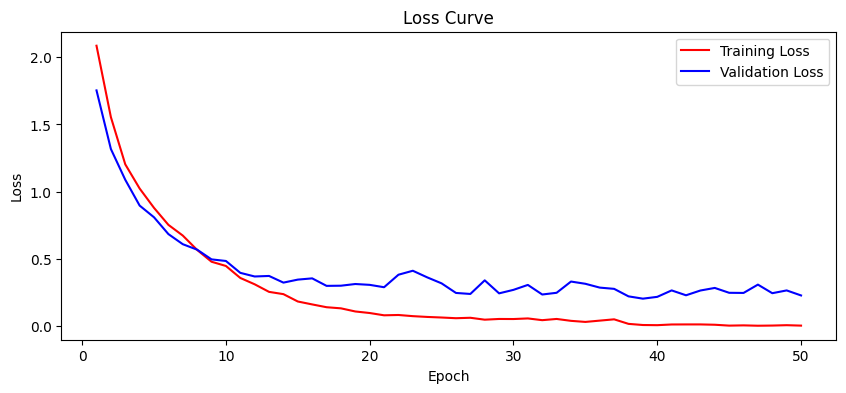

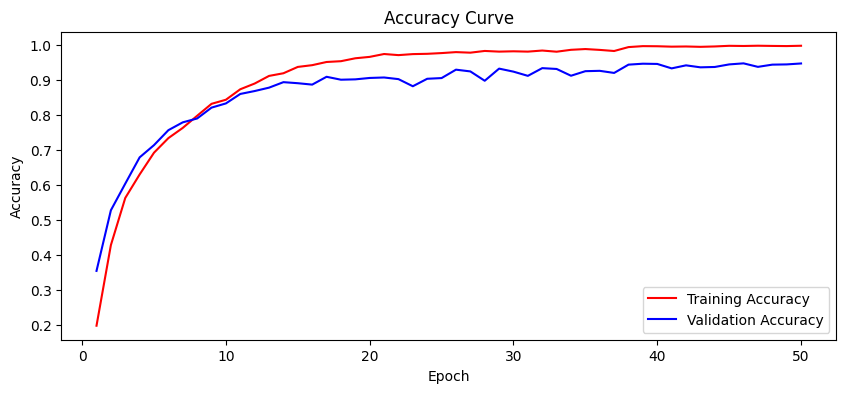

In [ ]:

# =================================================
# 11) رسم نمودار Loss و Accuracy
# =================================================
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10,4))
plt.plot(epochs, history.history['loss'], 'r-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'b-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epochs, history.history['accuracy'], 'r-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'b-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

<div dir="rtl" align="right">

### رسم نمودار Loss و Accuracy - بخش یازدهم

#### هدف این مرحله
- در این بخش، دو نمودار رسم می‌شود:
  - نمودار **`Loss Curve`** برای بررسی تغییرات مقدار تابع هزینه در طول فرآیند آموزش.
  - نمودار **`Accuracy Curve`** برای مشاهده پیشرفت دقت مدل در هر دوره (epoch).
- این نمودارها به تحلیل عملکرد مدل و شناسایی مشکلات احتمالی در آموزش کمک می‌کنند.

#### تعریف متغیر `epochs`
- متغیر `epochs` نشان‌دهنده تعداد کل دوره‌ها (epochs) است.
- این متغیر به عنوان محور افقی (X) در هر دو نمودار استفاده می‌شود.
- مقدار آن از ۱ شروع شده و به تعداد کل دوره‌ها (`len(history.history['loss'])`) ختم می‌شود.

#### رسم نمودار Loss
1. **تعریف نمودار**:
   - با استفاده از تابع `plt.figure`، اندازه نمودار به ۱۰x۴ تنظیم می‌شود.
2. **رسم داده‌های آموزشی**:
   - مقادیر تابع هزینه برای داده‌های آموزشی (`history.history['loss']`) با خط قرمز (`r-`) رسم می‌شوند.
3. **رسم داده‌های اعتبارسنجی**:
   - مقادیر تابع هزینه برای داده‌های اعتبارسنجی (`history.history['val_loss']`) با خط آبی (`b-`) رسم می‌شوند.
4. **تنظیمات نمودار**:
   - محور X با برچسب `Epoch` و محور Y با برچسب `Loss` مشخص می‌شوند.
   - عنوان نمودار **`Loss Curve`** تنظیم می‌شود.
   - یک راهنمای (legend) اضافه می‌شود تا خطوط مربوط به آموزش و اعتبارسنجی تفکیک شوند.
5. **نمایش نمودار**:
   - با استفاده از `plt.show()`، نمودار Loss نمایش داده می‌شود.

#### رسم نمودار Accuracy
1. **تعریف نمودار**:
   - یک نمودار جدید با ابعاد مشابه برای دقت تعریف می‌شود.
2. **رسم داده‌های آموزشی**:
   - مقادیر دقت برای داده‌های آموزشی (`history.history['accuracy']`) با خط قرمز (`r-`) رسم می‌شوند.
3. **رسم داده‌های اعتبارسنجی**:
   - مقادیر دقت برای داده‌های اعتبارسنجی (`history.history['val_accuracy']`) با خط آبی (`b-`) رسم می‌شوند.
4. **تنظیمات نمودار**:
   - محور X با برچسب `Epoch` و محور Y با برچسب `Accuracy` مشخص می‌شوند.
   - عنوان نمودار **`Accuracy Curve`** تنظیم می‌شود.
   - یک راهنمای (legend) اضافه می‌شود.
5. **نمایش نمودار**:
   - نمودار Accuracy نیز مشابه Loss نمایش داده می‌شود.

#### اهمیت این مرحله
- **نمودار Loss**:
  - کاهش پیوسته مقدار تابع هزینه نشان‌دهنده بهبود عملکرد مدل است.
  - اگر مقدار تابع هزینه برای داده‌های آموزشی کاهش یابد ولی برای داده‌های اعتبارسنجی افزایش یابد، مدل احتمالاً دچار **overfitting** شده است.
- **نمودار Accuracy**:
  - افزایش دقت در هر دوره نشان‌دهنده یادگیری بهتر مدل است.
  - اختلاف زیاد بین دقت آموزشی و اعتبارسنجی می‌تواند نشانه‌ای از **overfitting** باشد.
- این نمودارها ابزار مفیدی برای نظارت و بهینه‌سازی فرآیند آموزش مدل هستند.

</div>


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step

=== Classification Report ===
              precision    recall  f1-score   support

       blues       0.94      0.97      0.96       302
   classical       0.97      0.99      0.98       298
     country       0.94      0.91      0.92       317
       disco       0.96      0.95      0.95       312
      hiphop       0.98      0.94      0.96       277
        jazz       0.98      0.96      0.97       311
       metal       0.96      0.97      0.97       302
         pop       0.93      0.96      0.94       289
      reggae       0.97      0.95      0.96       296
        rock       0.85      0.90      0.87       291

    accuracy                           0.95      2995
   macro avg       0.95      0.95      0.95      2995
weighted avg       0.95      0.95      0.95      2995



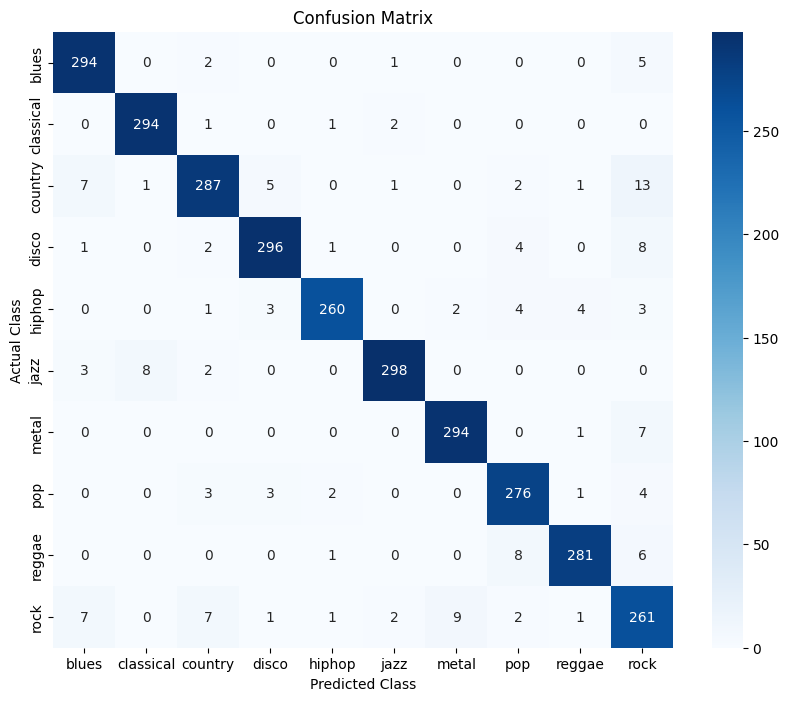

In [ ]:


# =================================================
# 12) گزارش طبقه‌بندی و ماتریس درهم‌ریختگی
# =================================================
y_pred = model.predict(X_test)
predicted_categories = np.argmax(y_pred, axis=1)
true_categories = np.argmax(y_test, axis=1)

print("\n=== Classification Report ===")
print(classification_report(true_categories, predicted_categories, target_names=classes))

cm = confusion_matrix(true_categories, predicted_categories)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()
